In [1]:
import pandas as pd
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

In [2]:
resume_df = pd.read_csv("clean_resume_data.csv")
print("Resume dataset loaded")
job_desc_df = pd.read_csv("jobs_dataset_with_features.csv")
print("Job description loaded")

Resume dataset loaded
Job description loaded


In [3]:
job_desc_df.rename(columns={'Role': 'Job_Title', 'Features': 'Job_Description'}, inplace=True)

In [4]:
job_desc_df.dropna(subset=['Job_Description'], inplace=True)
resume_df.dropna(subset=['Feature'], inplace=True)

In [5]:
resume_df.rename(columns={'Feature': 'Resume'}, inplace=True)

In [6]:
job_desc_df.reset_index(drop=True, inplace=True)
resume_df.reset_index(drop=True, inplace=True)

In [7]:
print("\nSample Job Descriptions:")
print(job_desc_df.head())


Sample Job Descriptions:
                   Job_Title  \
0       Social Media Manager   
1     Frontend Web Developer   
2    Quality Control Manager   
3  Wireless Network Engineer   
4         Conference Manager   

                                     Job_Description  
0  5 to 15 Years Digital Marketing Specialist M.T...  
1  2 to 12 Years Web Developer BCA HTML, CSS, Jav...  
2  0 to 12 Years Operations Manager PhD Quality c...  
3  4 to 11 Years Network Engineer PhD Wireless ne...  
4  1 to 12 Years Event Manager MBA Event planning...  


In [8]:
nlp = spacy.load("en_core_web_sm")

In [10]:
def preprocess_text(text):
    """Cleans and preprocesses text."""
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
resume_df['Cleaned_Resume_Text'] = resume_df['Resume'].apply(preprocess_text)
job_desc_df['Cleaned_Job_Description'] = job_desc_df['Job_Description'].apply(preprocess_text)

In [12]:
vectorizer = TfidfVectorizer(max_features=7000, min_df=3, max_df=0.8)
resume_vectors = vectorizer.fit_transform(resume_df['Cleaned_Resume_Text'])
job_vectors = vectorizer.transform(job_desc_df['Cleaned_Job_Description'])

print(" TF-IDF Vectorization")

 TF-IDF Vectorization


In [14]:
def find_top_k_resumes(resume_vectors, job_vectors, k=5):
    """Finds top-k most similar resumes for each job using Nearest Neighbors."""
    model = NearestNeighbors(n_neighbors=k, metric="cosine", algorithm="auto")
    model.fit(resume_vectors)  # Fit on resume vectors

    top_matches = {}

    for job_idx in range(job_vectors.shape[0]):
        job_vector = job_vectors[job_idx].reshape(1, -1)
        distances, indices = model.kneighbors(job_vector, return_distance=True)

        job_title = job_desc_df.iloc[job_idx]["Job_Title"]
        top_matches[job_title] = [
            (resume_df.iloc[i]["Resume"], 1 - distances[0][j]) for j, i in enumerate(indices[0])
        ]

    return top_matches

top_matches = find_top_k_resumes(resume_vectors, job_vectors, k=5)

In [15]:
def rank_resumes_for_job(job_title, top_n=5):
    if job_title not in top_matches:
        print(f" Error: '{job_title}' not found. Choose from: {list(top_matches.keys())}")
        return pd.DataFrame()

    ranked_resumes = sorted(top_matches[job_title], key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(ranked_resumes, columns=["Resume", "Match Score"])

In [16]:
def plot_resume_scores(job_title):
    ranked_resumes = rank_resumes_for_job(job_title)

    if ranked_resumes.empty:
        print(f"Error: No resumes found for '{job_title}'. Try another job title.")
        return
    
    y_labels = [text[:50] for text in ranked_resumes["Resume"]]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=ranked_resumes["Match Score"], y=y_labels, hue=y_labels, palette="Blues_r", legend=False)
    
    plt.xlabel("Match Score")
    plt.ylabel("Resumes")
    plt.title(f"Top Resume Matches for {job_title}")
    plt.show()

In [17]:
def plot_similarity_distribution():
    all_scores = [score for job in top_matches for _, score in top_matches[job]]
    
    plt.figure(figsize=(8, 5))
    plt.hist(all_scores, bins=20, color='blue', edgecolor='black')
    plt.xlabel("Similarity Score")
    plt.ylabel("Number of Resumes")
    plt.title("Distribution of Resume Similarity Scores")
    plt.show()


Top Resumes for 'Data Analyst Researcher':
                                              Resume  Match Score
0  pavithra shetty summary customer oriented prin...     0.342927
1  senior digital marketing analyst summary highl...     0.296020
2  data analyst professional summary industrial s...     0.293047
3  engineering quality technician career overview...     0.289513
4  sales coordinator summary current ms data anal...     0.263281


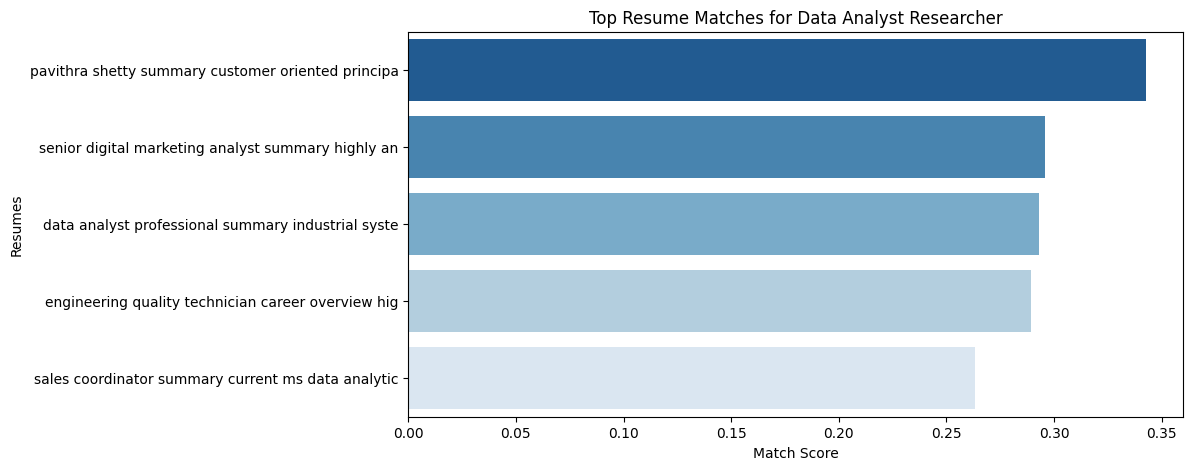

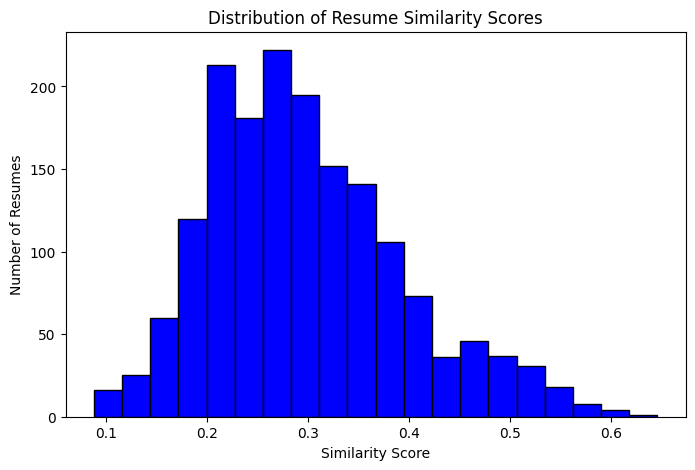

In [19]:
job_title = "Data Analyst Researcher"
top_resumes = rank_resumes_for_job(job_title)

if not top_resumes.empty:
    print(f"\nTop Resumes for '{job_title}':")
    print(top_resumes)
else:
    print(f"No matching resumes found for '{job_title}'.")

plot_resume_scores("Data Analyst Researcher")
plot_similarity_distribution()